In [8]:
from sklearn.linear_model import LinearRegression
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# Загрузим данные в датафрейм
states = pd.read_csv('D:\BSNS\STUDY\Stepik\Основы Статистики\states.csv')

In [4]:
states.head()

,state,metro_res,white,hs_grad,poverty,female_house
0,Alabama,55.4,71.3,79.9,14.6,14.2
1,Alaska,65.6,70.8,90.6,8.3,10.8
2,Arizona,88.2,87.7,83.8,13.3,11.1
3,Arkansas,52.5,81.0,80.9,18.0,12.1
4,California,94.4,77.5,81.1,12.8,12.6


#### Линейная регрессионная модель с двумя независимыми переменными

In [5]:
X = states[['white', 'hs_grad']] # НП
y = states['poverty'] # ЗП

In [6]:
# Линейная регрессионная модель
reg = LinearRegression().fit(X, y)

In [7]:
d1, d2 = [], []
for x1 in np.linspace(min(states['white']), max(states['white']), 100): # задаем ось x от min до max по x
    for x2 in np.linspace(min(states['hs_grad']), max(states['hs_grad']), 100): # задаем ось y от min до max по y
        d1.append(x1)
        d2.append(x2)
d1 = np.array(d1).reshape(-1, 1)
d2 = np.array(d2).reshape(-1, 1)
p = reg.predict(np.concatenate([d1, d2], axis=1))

<IPython.core.display.Javascript object>


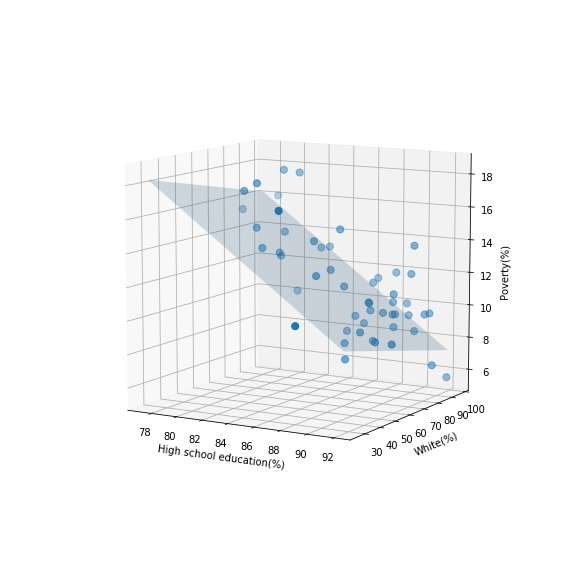

In [12]:
# Построим 3-мерный график для 2-х независимых переменных
%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(8, 8))
ax = plt.axes(projection='3d')

ax.scatter(states['hs_grad'], states['white'], states['poverty'], s=50)

ax.plot_trisurf(d2.ravel(), d1.ravel(), p.ravel(), alpha=0.2)

ax.set_xlabel('High school education(%)')
ax.set_ylabel('White(%)')
ax.set_zlabel('Poverty(%)')

ax.elev = 10
ax.azim = -60

#### Расчет статистики для 4-х независимых переменных

In [13]:
import statsmodels.api as sm

In [14]:
# Независимая переменная
X = states['poverty']
# Зависимые переменные
Y = sm.add_constant(states[['metro_res', 'white', 'hs_grad', 'female_house']])

In [15]:
# Обучение модели
model = sm.OLS(X, Y).fit()
# Вывод результатов
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                poverty   R-squared:                       0.642
Model:                            OLS   Adj. R-squared:                  0.610
Method:                 Least Squares   F-statistic:                     20.58
Date:                Sun, 27 Feb 2022   Prob (F-statistic):           8.88e-10
Time:                        17:58:25   Log-Likelihood:                -103.39
No. Observations:                  51   AIC:                             216.8
Df Residuals:                      46   BIC:                             226.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           66.4765     12.590      5.280   

#### Выбор наилучшей модели

In [16]:
# Корреляция между переменными нашей модели
corr = states.corr()
corr

,metro_res,white,hs_grad,poverty,female_house
metro_res,1.000000,-0.342442,0.018110,-0.204235,0.300062
white,-0.342442,1.000000,0.238156,-0.308520,-0.751394
hs_grad,0.018110,0.238156,1.000000,-0.746858,-0.611867
poverty,-0.204235,-0.308520,-0.746858,1.000000,0.525397
female_house,0.300062,-0.751394,-0.611867,0.525397,1.000000


<IPython.core.display.Javascript object>


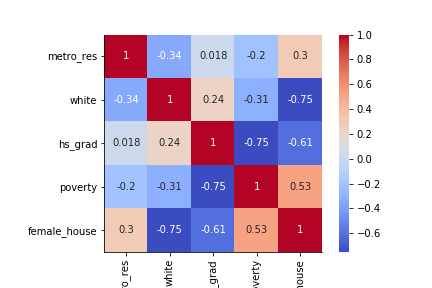

In [35]:
# Корреляция между переменными нашей модели. График heatmap
import seaborn as sns

features = states.columns
f,ax = plt.subplots(1,1)
sns.heatmap(states[features].corr(), annot=True, square=True, cmap='coolwarm')
sns.despine()

<IPython.core.display.Javascript object>


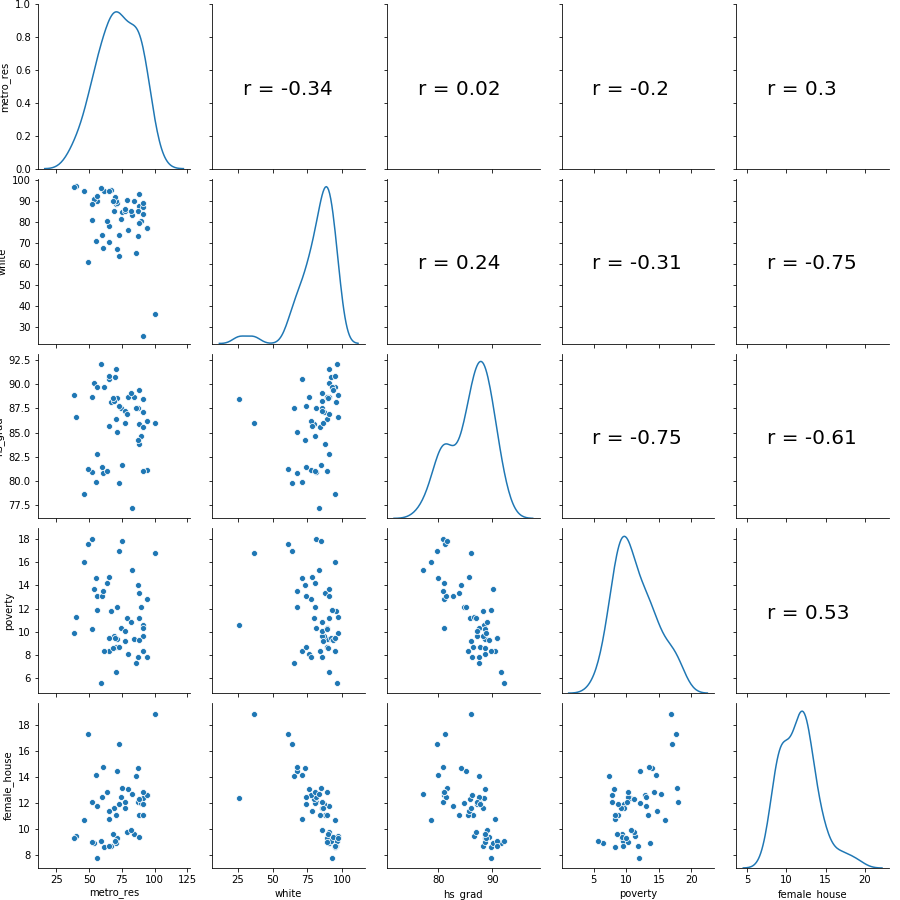

In [20]:
# Функция для расчета коэффициента корреляции между двумя переменными
def corr(x, y, **kwargs):
    # Calculate the value
    coef = np.corrcoef(x, y)[0][1]
    # Make the label
    label = 'r = ' + str(round(coef, 2))
    # Add the label to the plot
    ax = plt.gca()
    ax.annotate(label, xy = (0.2, 0.45), size = 20, xycoords = ax.transAxes)

g = sns.PairGrid(states, diag_sharey=False)
# g.map_upper(sns.scatterplot)
g.map_upper(corr)
g.map_lower(sns.scatterplot)
g.map_diag(sns.kdeplot)
sns.despine()

In [21]:
# Если между двумя какими-либо независимыми переменными наблюдается высокая кореляция, наша модель становится слабее,
# Мы наблюдаем высокую корреляцию между 'female_house' и другими предикторами. 
# Возможно, стоит вывести эту переменную из нашей модели

In [23]:
# Наконец, выберем лучшие переменные для построения нашей модели
import statsmodels.formula.api as smf

# Найдём такой набор предикторов, что R-squared максимальна
feats = {'metro_res', 'white', 'hs_grad', 'female_house'}

# Рекурсивно переберём все сочетания переменных
def brute_force(params: set, formula: str, result: set) -> str:
    if not params:
        result.add(formula.lstrip('+ '))
        return 
    else:
        new_params = params.copy()
        for el in params:
            new_params.remove(el)

            brute_force(new_params, formula + ' + ' + el, result)
            brute_force(new_params, formula, result)

res = set()          
brute_force(feats, '', res)
res.remove('')

results = {}

# Теперь посчитаем Adjusted R-Square для каждого сочетания и выведем на экран
for formula in res:
    lm = smf.ols(formula='poverty ~ ' + formula, data=states).fit()
    results[formula] = f'{lm.rsquared_adj:.2}'

# Выведем отсортированные результаты на экран
d = sorted(results.items(), key=lambda x: x[1], reverse=True)
for i in d:
    print(i[1],'\t',i[0])

0.62 	 metro_res + hs_grad + white
0.61 	 metro_res + hs_grad + female_house + white
0.6 	 metro_res + hs_grad + female_house
0.58 	 metro_res + hs_grad
0.56 	 hs_grad + white
0.55 	 hs_grad
0.55 	 hs_grad + female_house
0.55 	 hs_grad + female_house + white
0.4 	 metro_res + female_house
0.39 	 metro_res + female_house + white
0.26 	 female_house + white
0.26 	 female_house
0.17 	 metro_res + white
0.077 	 white
0.022 	 metro_res


In [24]:
# Наиболее точный результат получим при использовании предикторов ['metro_res', 'hs_grad', 'white']

In [27]:
data_crop = states[['white', 'hs_grad', 'poverty']]
data_crop.head()

,white,hs_grad,poverty
0,71.3,79.9,14.6
1,70.8,90.6,8.3
2,87.7,83.8,13.3
3,81.0,80.9,18.0
4,77.5,81.1,12.8


In [28]:
white, hs_grad, poverty = [column for column in data_crop.values.T]

<IPython.core.display.Javascript object>


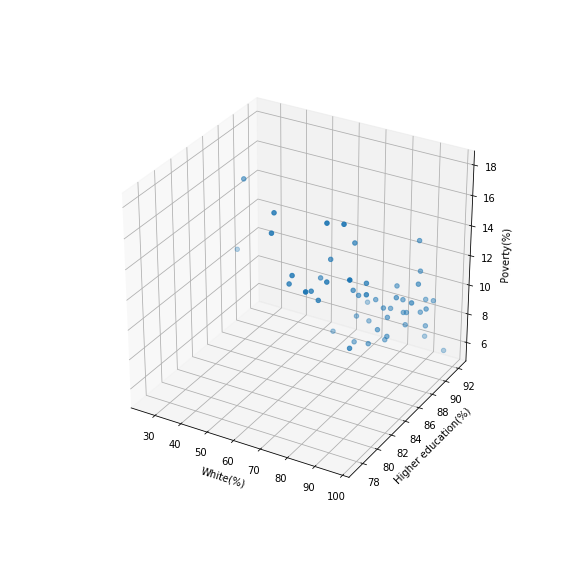

Text(0.5, 0, 'Poverty(%)')

In [42]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs=white, ys=hs_grad, zs=poverty)

ax.set_xlabel('White(%)')
ax.set_ylabel('Higher education(%)')
ax.set_zlabel('Poverty(%)')

In [29]:
# Пример прогноза бедности
b0 = 68.7
b1 = -0.06
b2 = -0.05
b3 = -0.57
x1 = 50   # white
x2 = 80   # metro_res
x3 = 90   # hs_grad
y = b0 + b1*x1 + b2*x2 + b3*x3
y

10.400000000000006